In [1]:
import pandas as pd
import numpy as np

In [2]:
df_all = pd.read_csv("../../data/processed/processed_apolar.csv")
df_partial = pd.read_csv("../../data/final/final_apolar.csv")
df_partial.head()

,Molecule,Formula,Ei,Alpha,Expt,axx,ayy,azz,pi_bond
0,Butane,C4H10,10.6,8.08,35,9.31,7.68,7.24,0
1,Pentane,C5H12,10.4,9.95,60,11.72,9.39,8.74,0
2,Hexane,C6H14,10.2,11.85,80,14.32,10.99,10.23,0
3,Heptane,C7H16,9.9,13.76,105,16.91,12.66,11.72,0
4,Octane,C8H18,10.0,15.68,115,19.60,14.26,13.19,0


,Molecule,Formula,Ei,Alpha,Expt,pi_bond
0,Butane,C4H10,10.6,8.1,35,0
1,Pentane,C5H12,10.4,10.0,60,0
2,Hexane,C6H14,10.2,11.8,80,0
3,Heptane,C7H16,9.9,13.7,105,0
4,Octane,C8H18,10.0,15.5,115,0


# 20 Molecules

In [4]:
# Separating between x's and y

# For all molecules we'll have the following combination:
# All Features; Ei + Alpha; Ei + Pi Bond; Alpha + Pi Bond

x0_all = df_all[['Ei', 'Alpha', 'pi_bond']]
x1_all = df_all[['Ei', 'Alpha']]
x2_all = df_all[['Ei', 'pi_bond']]
x3_all = df_all[['Alpha', 'pi_bond']]

y_all = df_all[['Expt']].values

x0_all.shape, x1_all.shape, x2_all.shape, x3_all.shape, y_all.shape


((20, 3), (20, 2), (20, 2), (20, 2), (20, 1))

In [5]:
# Importing regressors and relevant functions

from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.linear_model import Ridge
from xgboost import XGBRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, RobustScaler, MinMaxScaler
from sklearn.compose import TransformedTargetRegressor
from skopt.space.space import Real, Categorical, Integer
from skopt.utils import use_named_args
from sklearn.model_selection import cross_val_score
from skopt import gp_minimize

In [6]:
# Defining spaces to optimize

pipe_elastic = Pipeline([('poli', PolynomialFeatures()), ('scale', MinMaxScaler()),  ('reg', Ridge(max_iter=30000))])
ridge = TransformedTargetRegressor(regressor = pipe_elastic, transformer = StandardScaler())

space_poli = [

    Real(1e-5,100, 'log-uniform', name='regressor__reg__alpha'),
    Categorical([True, False], name = 'regressor__reg__fit_intercept'),
    Categorical([True, False], name = 'regressor__reg__copy_X'),
    Integer(1,10,name='regressor__poli__degree'),
    Categorical([True,False], name='regressor__poli__interaction_only'),
    Categorical([True,False], name = 'regressor__poli__include_bias'),
    Categorical([StandardScaler(),MinMaxScaler(),RobustScaler()], name = "regressor__scaling"),
    Categorical([StandardScaler(),MinMaxScaler(),RobustScaler()], name = "transformer")

]

pipe_svr = Pipeline([('scale',StandardScaler()),('reg',SVR(max_iter=10000))])
svr = TransformedTargetRegressor(transformer = StandardScaler(), regressor = pipe_svr)

space_svr = [
    Categorical(['rbf','sigmoid','poly'], name = 'regressor__reg__kernel'),
    Categorical(['scale','auto'], name = 'regressor__reg__gamma'),
    Integer(1,10, name = 'regressor__reg__degree'),
    Real(0, 10, name = 'regressor__reg__coef0'),
    Real(0.1, 5, name = 'regressor__reg__C'),
    Real(0.01, 5, name = 'regressor__reg__epsilon'),
    Categorical([StandardScaler(),MinMaxScaler(),RobustScaler()], name = "regressor__scale"),
    Categorical([StandardScaler(),MinMaxScaler(),RobustScaler()], name = "transformer") 
]

xgb = XGBRegressor(random_state=0)

space_xgb = [
    Real(10e-5,0.2,  "log-uniform", name='learning_rate'),
    Integer(100,2000,name = 'n_estimators'),
    Integer(1,15,name='max_depth'),
    Integer(1,15,name='min_child_weight'),
    Real(0, 6, name='gamma'),
    Real(0.1, 1, name='subsample'),
    Real(0.1,1,name='colsample_bytree'),
    Real(0,1,name="reg_alpha"),
    Real(0,1,name="reg_lambda")
]

pipe = Pipeline([('scale', MinMaxScaler()), ('reg', MLPRegressor(max_iter = 5000, random_state = 0, solver = 'adam'))])
nn = TransformedTargetRegressor(regressor = pipe, transformer = StandardScaler())

space_nn = [
    Categorical(['tanh','relu','logistic'], name = 'regressor__reg__activation'),
    Real(1e-6,1e-3,prior='log-uniform', name = 'regressor__reg__learning_rate_init'),
    Integer(1,20,name='n_hidden_layer'),
    Integer(1,20,name='n_neurons_per_layer'),
    Real(0.5,0.9,name = 'regressor__reg__beta_1'),
    Real(0.5,0.9,name = 'regressor__reg__beta_2'),
    Real(1e-7, 1e-5, name = 'regressor__reg__epsilon'),
    Categorical([StandardScaler(),MinMaxScaler(),RobustScaler()], name = "regressor__scale"),
    Categorical([StandardScaler(),MinMaxScaler(),RobustScaler()], name = "transformer")
    ]

In [7]:
# Defining an optimizer
def change_nn_params(params):
    n_neurons=params['n_neurons_per_layer']
    n_layers=params['n_hidden_layer']
    
    params['regressor__reg__hidden_layer_sizes']=(n_neurons,)*n_layers
    
    # the parameters are deleted to avoid an error from the MLPRegressor
    params.pop('n_neurons_per_layer')
    params.pop('n_hidden_layer')

def gp_optimize(estim,x,y,space,cv,n_calls=150,n_random_starts=100,neural=False,
                scoring="neg_mean_absolute_percentage_error", n_jobs_cv = -1,
                n_jobs_opt = -1, verbose= 0):
  kf = KFold(n_splits=cv, shuffle=True, random_state=0)  
  @use_named_args(space)
  def objective(**params):
      if neural == True:
        change_nn_params(params)

      estim.set_params(**params)
      
      mean_score = -np.mean(cross_val_score(estim, x, y, cv=cv, scoring=scoring, n_jobs = n_jobs_cv, error_score= -100))

      if mean_score > 1000:
         mean_score = 100
         
      return mean_score
  

  gp_optimize.opt = gp_minimize(objective, space, n_calls=n_calls, random_state=0, 
                                n_random_starts=n_random_starts,verbose=verbose, n_jobs = n_jobs_opt)
  #print("Os hiper parâmetros que minimizam são: ", gp_optimize.opt.x)
  return gp_optimize.opt

# 17 Molecules

In [8]:
x_partial = df_partial[['axx', 'ayy', 'azz']]
y_partial = df_partial[['Expt']]
x_partial.shape, y_partial.shape

((17, 3), (17, 1))

In [9]:
%cd '/home/miguel/Documentos/Master-Degree-Research/Positron-Binding-Energy/src'

/home/miguel/Documentos/Master-Degree-Research/Positron-Binding-Energy/src


In [10]:
x_partial

,axx,ayy,azz
0,9.31,7.68,7.24
1,11.72,9.39,8.74
2,14.32,10.99,10.23
3,16.91,12.66,11.72
4,19.60,14.26,13.19
5,21.31,14.93,14.01
6,5.43,3.77,3.35
7,5.75,5.75,5.04
8,11.29,11.29,9.78
9,12.27,12.27,6.67


In [30]:
import seaborn as sns
import matplotlib.pyplot as plt
def kde_plot(X, column_names, title = 'Distribuição das Colunas'):
    for i,j in enumerate(column_names):
        sns.kdeplot(X[:, i], label=j)

    # Definir título e rótulos dos eixos
    plt.title(title)
    plt.xlabel('Valores')
    plt.ylabel('Densidade')

    # Exibir a legenda
    plt.legend()

    # Exibir o gráfico
    plt.show()

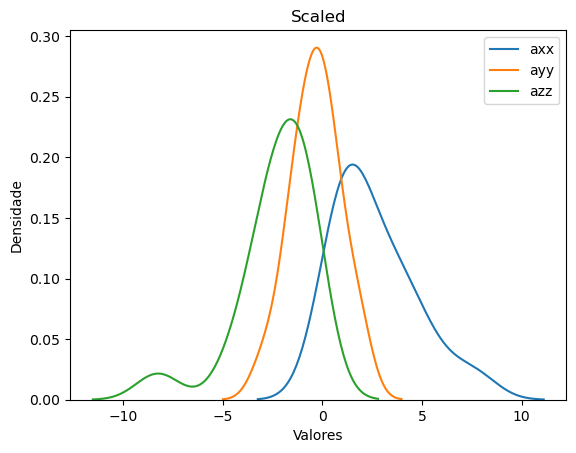

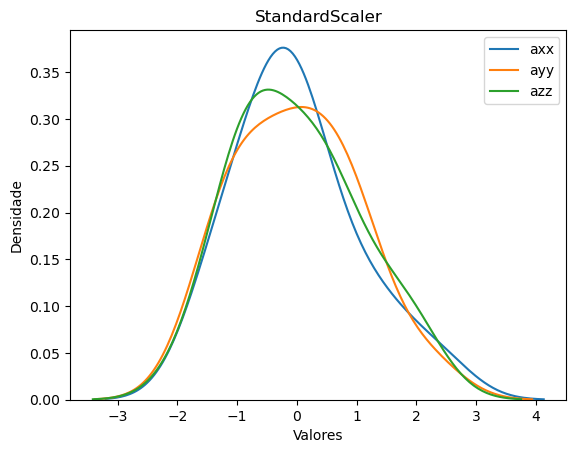

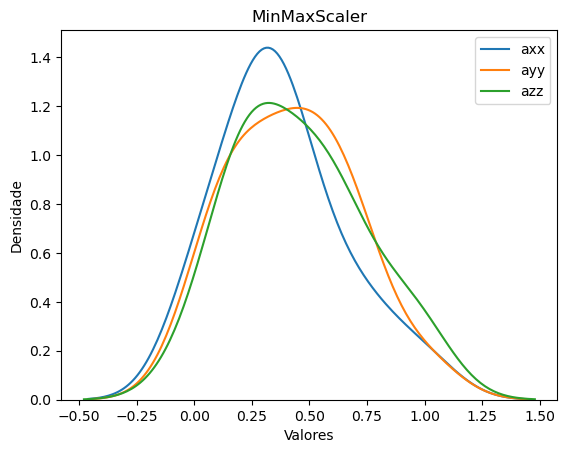

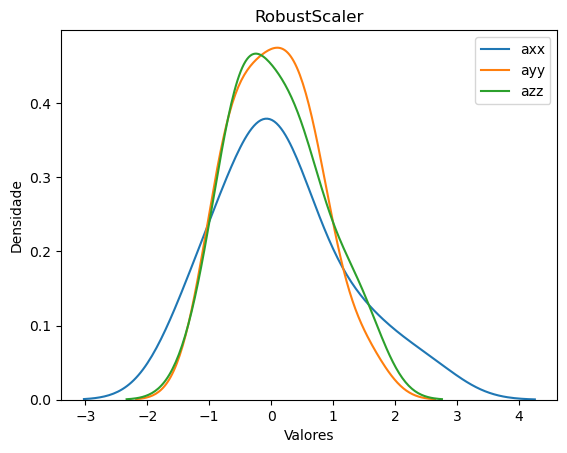

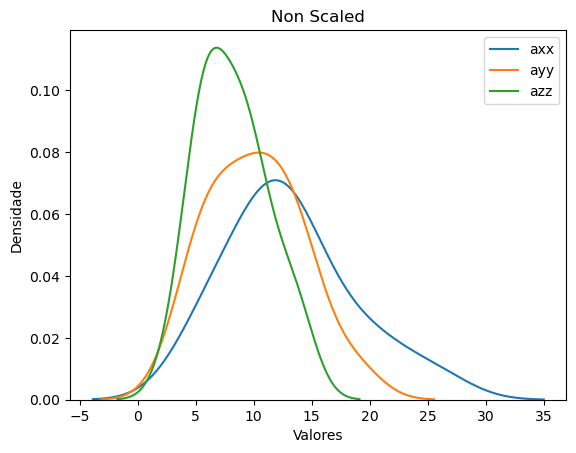

In [36]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import scale

x_scale = scale(x_partial, axis=1, with_mean=True, with_std=False)
column_names = ['axx', 'ayy', 'azz']
kde_plot(x_scale, column_names, title='Scaled')
kde_plot(StandardScaler().fit_transform(x_partial), column_names, title= 'StandardScaler')
kde_plot(MinMaxScaler().fit_transform(x_partial), column_names, title = 'MinMaxScaler')
kde_plot(RobustScaler().fit_transform(x_partial), column_names, title = "RobustScaler")
kde_plot(x_partial.values, column_names, title='Non Scaled')

In [34]:
from utils.evaluation import show_metrics

pipe_elastic = Pipeline([('poli', PolynomialFeatures()), ('scale', RobustScaler()),  ('reg', Ridge(max_iter=30000))])
ridge = TransformedTargetRegressor(regressor = pipe_elastic, transformer = StandardScaler())

show_metrics(ridge, x_partial, y_partial, 10)

Test Scores: [0.07467628 0.04049821 0.22358188 0.66808846 0.43068934 0.36015999
 0.78071036 1.60763888 3.53183494 0.47334238]
Mean Test Scores: 0.82
Std of Scores: 1.0
Min and Max of Scores: 0.04, 3.53

Train Score: 0.47



In [38]:
x_partial_all = df_partial[['Ei','axx', 'ayy', 'azz','pi_bond']]

In [60]:
ct = ColumnTransformer([('scale', StandardScaler(), [0, 1,2,3])], remainder='passthrough')

pipe_elastic = Pipeline([('poli', PolynomialFeatures()),  ('scale', ct), ('reg', Ridge(max_iter=30000))])
ridge = TransformedTargetRegressor(regressor = pipe_elastic, transformer = StandardScaler())

show_metrics(ridge, x_partial_all, y_partial, 10)

Test Scores: [0.0522944  0.04068174 0.0759586  1.44346889 0.05500115 0.34533815
 0.56722762 1.06264557 1.29889798 0.27822107]
Mean Test Scores: 0.52
Std of Scores: 0.52
Min and Max of Scores: 0.04, 1.44

Train Score: 0.04



In [74]:
pipe_elastic = Pipeline([('poli', PolynomialFeatures()) ,('reg', Ridge(max_iter=30000))])
ridge = TransformedTargetRegressor(regressor = pipe_elastic, transformer = StandardScaler())

show_metrics(ridge, x_partial_all, y_partial, 10)

Test Scores: [0.05164259 0.0425816  0.07560004 1.47178992 0.0550052  0.34570822
 0.57027063 1.06164333 1.29459328 0.27563191]
Mean Test Scores: 0.52
Std of Scores: 0.52
Min and Max of Scores: 0.04, 1.47

Train Score: 0.04

